The same preprocessed dataset is being used in both comp.ipynb and try.ipynb notebook

The preprocessed dataset is being created from Huwaei Private Cloud 2023 from following directories
    <li>1. Requests Per Minute </li>
    <li>2. CPU Usage Per Minute </li>
    <li>3. Memory Usage Per Minute </li>

In [39]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])

Do the forward fill

In [56]:
df.head()

,requests,memory,cpu
timestamp,,,
2023-10-01 00:00:00,6.0,0.105,0.003
2023-10-01 00:01:00,29.0,0.104,0.004
2023-10-01 00:02:00,12.0,0.105,0.003
2023-10-01 00:03:00,18.0,0.105,0.004
2023-10-01 00:04:00,4.0,0.105,0.003


In [41]:
# did the forward fill
df = df.fillna(method='ffill', axis=1).fillna(0)

/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_24346/2194621746.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)
/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_24346/2194621746.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(method='ffill', axis=1).fillna(0)
/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_24346/2194621746.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

In [42]:
df.head()

,requests,memory,cpu,timestamp
0,6.0,0.105,0.003,2023-10-01 00:00:00
1,29.0,0.104,0.004,2023-10-01 00:01:00
2,12.0,0.105,0.003,2023-10-01 00:02:00
3,18.0,0.105,0.004,2023-10-01 00:03:00
4,4.0,0.105,0.003,2023-10-01 00:04:00


In [43]:
has_null = df.isnull().any()

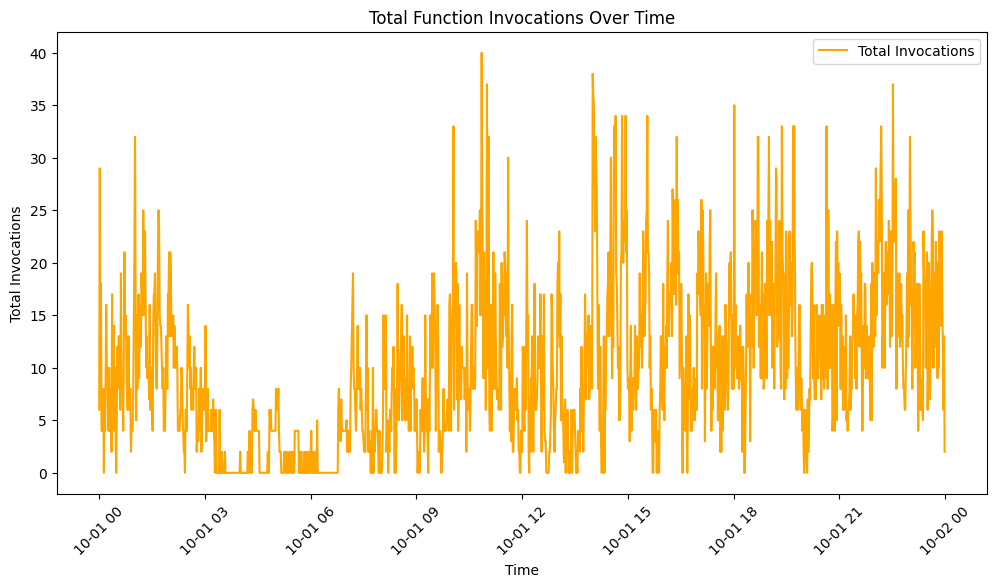

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['requests'], label="Total Invocations", color='orange')
plt.xlabel("Time")
plt.ylabel("Total Invocations")
plt.title("Total Function Invocations Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### find the p,q,d values for ARIMA

Function for determining whether data is stationary or not

In [46]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

time_series = df['requests']
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] < 0.05:
        print("Conclusion: The series is stationary (d=0).")
    else:
        print("Conclusion: The series is NOT stationary. Differencing required (d=1).")

# Run ADF test
adf_test(time_series)

ADF Statistic: -3.5635634074044034
p-value: 0.0064970645211175964
Critical Values:
	1%: -3.434979825137732
	5%: -2.8635847436211317
	10%: -2.5678586114197954
Conclusion: The series is stationary (d=0).


PACF Plot for determining p

<Figure size 1200x500 with 0 Axes>

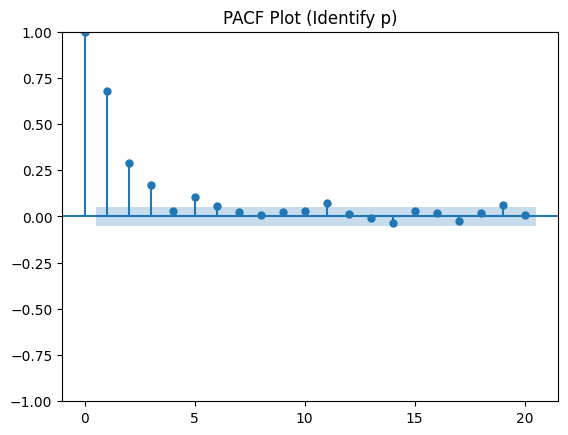

In [47]:
plt.figure(figsize=(12, 5))
plot_pacf(df['requests'], lags=20)
plt.title("PACF Plot (Identify p)")
plt.show()

p = 3 have largest spike, so p = 3

<Figure size 1200x500 with 0 Axes>

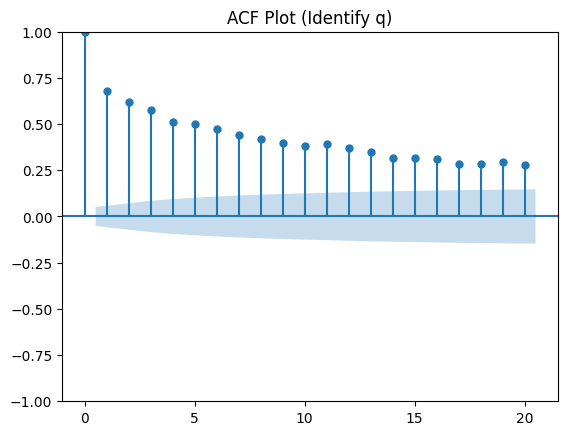

In [48]:
plt.figure(figsize=(12, 5))
plot_acf(df['requests'], lags=20)
plt.title("ACF Plot (Identify q)")
plt.show()

there is not much difference in spikes, so just choose q = 0

In [49]:
# Ensure time is the index
df.set_index('timestamp', inplace=True)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)  # 80% data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [51]:
# Train ARIMA Model
arima_model = ARIMA(train['requests'], order=(3,0,0)).fit()

# Forecast
arima_forecast = arima_model.forecast(len(test))

/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


In [53]:
import numpy as np

# Function to compute evaluation metrics
def evaluate_forecast(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))  # Root Mean Squared Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100  # Mean Absolute Percentage Error

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [54]:
metrics = evaluate_forecast(test['requests'], arima_forecast)

In [55]:
print(f"ARIMA Model Metrics:")
print(f"MAE: {metrics['MAE']:.2f}")
print(f"RMSE: {metrics['RMSE']:.2f}")
print(f"MAPE: {metrics['MAPE']:.2f}")

ARIMA Model Metrics:
MAE: 6.61
RMSE: 8.53
MAPE: 47.69
